In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [9]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format=".", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    plt.grid(False)  # was True

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-03-08 04:35:14--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.009s  

2022-03-08 04:35:14 (7.11 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



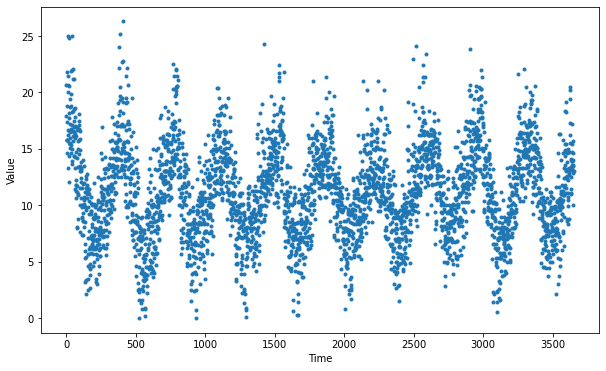

In [32]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
        reader = csv.reader(csvfile)# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
        next(reader)
        n = 1
        for row in reader:# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
            time_step.append(int(n))
            temps.append(float(row[1]))
            n +=1
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

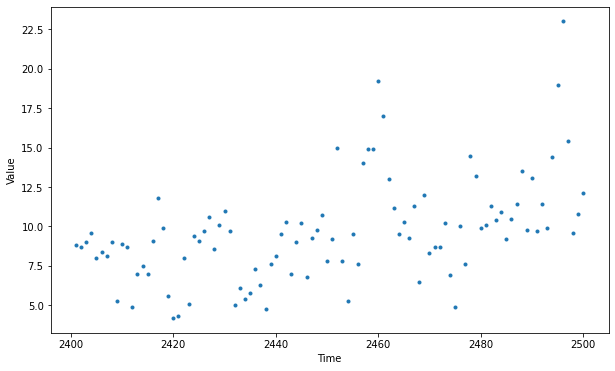

In [33]:
plt.figure(figsize=(10, 6))
plot_series(time[2400: 2500], series[2400: 2500])

In [34]:
print(len(time))
print(type(time))
print(time.shape)

3650
<class 'numpy.ndarray'>
(3650,)


In [35]:
split_time = 3000  # was 2500
time_train = time[:split_time]# YOUR CODE HERE
x_train = series[:split_time]# YOUR CODE HERE
time_valid = time[split_time:]# YOUR CODE HERE
x_valid = series[split_time:]# YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [36]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder = True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda w: (w[:-1], w[1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
    # YOUR CODE HERE


In [37]:
def model_forecast(model, series, window_size): # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                               strides = 1, padding='causal',
                               activation = 'relu',
                               input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences = True),
        tf.keras.layers.LSTM(64, return_sequences = True),
        tf.keras.layers.Dense(30, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x : x * 100)
])
# YOUR CODE HERE

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)
Epoch 1/100
12/12 [==============================] - 8s 325ms/step - loss: 15.9469 - mae: 16.4467 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 4s 326ms/step - loss: 15.8988 - mae: 16.3986 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 4s 326ms/step - loss: 15.8283 - mae: 16.3281 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 4s 321ms/step - loss: 15.7435 - mae: 16.2433 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 4s 318ms/step - loss: 15.6458 - mae: 16.1456 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 5s 364ms/step - loss: 15.5343 - mae: 16.0341 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 4s 322ms/step - loss: 15.4063 - mae: 15.9060 - lr: 1.9953e-08
Epoch 8/100
12/12 [========

(1e-08, 0.0001, 0.0, 60.0)

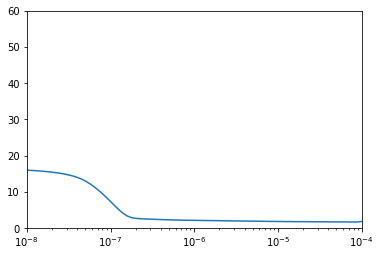

In [39]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [42]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                               strides = 1, padding='causal',
                               activation = 'relu',
                               input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences = True),
        tf.keras.layers.LSTM(64, return_sequences = True),
        tf.keras.layers.Dense(30, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x : x * 100)
# YOUR CODE HERE
])


optimizer = tf.keras.optimizers.SGD(learning_rate= 1e-4, momentum=0.9) # YOUR CODE HERE
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100) # YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100
30/30 [==============================] - 8s 131ms/step - loss: 4.0811 - mae: 4.5531
Epoch 2/100
30/30 [==============================] - 4s 129ms/step - loss: 1.9182 - mae: 2.3718
Epoch 3/100
30/30 [==============================] - 4s 126ms/step - loss: 1.7615 - mae: 2.2108
Epoch 4/100
30/30 [==============================] - 4s 124ms/step - loss: 1.7138 - mae: 2.1618
Epoch 5/100
30/30 [==============================] - 4s 128ms/step - loss: 1.6745 - mae: 2.1215
Epoch 6/100
30/30 [==============================] - 4s 126ms/step - loss: 1.6420 - mae: 2.0888
Epoch 7/100
30/30 [==============================] - 4s 140ms/step - loss: 1.6292 - mae: 2.0756
Epoch 8/100
30/30 [==============================] - 4s 125ms/step - loss: 1.6224 - mae: 2.0683
Epoch 9/100
30/30 [==============================] - 4s 128ms/step - loss: 1.5993 - mae: 2.0449
Epoch 10/100
30/30 [==============================] - 4s 131ms/step - loss: 1.5751 - mae: 2.0199
Epoch 11/100
30/30 [===================

In [43]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

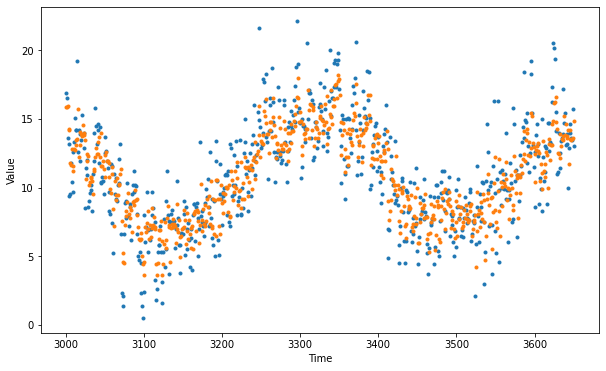

In [44]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [45]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7300973

In [46]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[15.865621  15.873253  15.971851  14.291906  14.220535  11.788708
 11.654959  12.781848  11.550177  11.203392  12.804258  12.740682
 13.458697  13.092618  13.551199  15.75741   12.261761  14.042385
 13.121702  13.890849  13.7340145 14.56003   13.800417  14.000379
 13.498857  10.653647  12.474198  11.916141  12.320128  10.21121
 10.415804  10.674484  10.733947  10.483815   9.559057  11.232497
 11.341117  12.209207  12.862842  12.462827  12.454648  13.3009405
 13.674554  12.204218  13.994442  11.591726  11.546733  11.941225
 11.382886  10.735891  12.392815  12.6062975 11.935623  11.907853
 11.801636  10.804632   9.864479   9.607992  11.51601   10.96199
  8.467739   7.1644335 10.458815   9.087613   9.452583  10.716211
  9.463932  10.261841  10.172044  10.991243  11.379725   7.5731277
  5.2643433  4.5420036  4.528307   7.2696424  8.315577   7.9452543
  8.965578   9.612672   8.073691   7.75227    8.558888   8.346253
  6.7634315  8.9589615  9.008356   8.749869   9.844406   9.099471
  9.17092